# Dinámica de entrelazamiento

En este notebook exploramos numéricamente la dinámica de entrelazamiento entre dos sistemas de dimensión dos, replicando la cuenta analítica que hicimos en clase, modificaciones más realistas de ella, y por último considerando los efectos que tiene interactuar con un entorno.

In [28]:
## Importamos librerías a usar

# Numpy y Scipy son librerías de cálculo numérico en Python
import numpy as np
import scipy as sp

# Qutip es una librería para mecánica cuántica numérica en Python
# (esta primer parte es para que funcione en Google Colab)
import os
if "COLAB_GPU" in os.environ:
  !pip install -q qutip
# (ahora sí importamos qutip de forma usual)
import qutip as qt
from qutip import basis, qeye, sigmax, sigmay, sigmaz, sigmap, sigmam, tensor, \
  mesolve, concurrence

# Matplotlib es para hacer lindos gráficos
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=12)
import matplotlib.pyplot as plt

Ejemplo de cómo crear la base producto del espacio de los dos sistmeas de dimensión 2.

In [20]:
# Base producto de autoestados de Sz
ket00 = tensor(basis(2,0),basis(2,0))
ket01 = tensor(basis(2,0),basis(2,1))
ket10 = tensor(basis(2,1),basis(2,0))
ket11 = tensor(basis(2,1),basis(2,1))

## Replicando los resultados del Problema 18

En este problema teníamos dos spin 1/2 que interactuaban entre sí con un Hamiltoniano
$$H = J\sigma_z\otimes\sigma_z,$$
que nos es más que una interacción efectiva de los dos momentos dipolares magnéticos de los spines. Nos interesaba estudiar la dinámica del entrelazamiento generado por esta interacción si partíamos de un estado producto.

El estado inicial del problema es el estado $|+,x\rangle\otimes|+,x\rangle$.
Para ello, definimos el estado de un spin 1/2, $|+,x\rangle = \frac{1}{\sqrt{2}}(|+\rangle + |-\rangle)$, y después simplemente tomamos producto tensorial.

In [21]:
# Autoestado +1 de Sx
ketXplus = (basis(2,0) + basis(2,1))/np.sqrt(2)

# Estado inicial: |+x>⊗|+x>
IniState = tensor(ketXplus,ketXplus)

Ahora definimos el Hamiltoniano, y la lista de tiempos para los cuales queremos tener el estado $|\Psi(t)\rangle_{AB}$.

In [22]:
# Hamiltoniano: J*Sz⊗Sz
J = 1.0
H = J*tensor(sigmaz(),sigmaz())

# Estado Inicial evolucionado
times = np.linspace(0, np.pi/J, 400)
res = mesolve(H, IniState, times)

Con la lista de estados $|\Psi(t)\rangle_{AB}$, calculamos las matrices densidad reducidas sobre la primer partícula, su pureza, y con ella la medida de entrelazamiento (válida para estados globalmente puros)
$$E(\Psi_{AB}(t)) = 1 - \rm{tr}[\rho_A^2(t)], \qquad \rho_A(t)=\rm{tr}_B[|\Psi_{AB}(t)\rangle\langle\Psi_{AB}(t)|]$$

In [23]:
# Estados reducidos primer subsistema, su pureza, y medida de entrelazamiento
reduced = [ state.ptrace(0) for state in res.states ]
purity = np.array([ (r**2).tr() for r in reduced ])
Eent = 1 - purity

Con todo esto (que calculamos analíticamente en clase) repliquemos el gráfico que obutivmos al final de la clase del entrelazamiento en función del tiempo.

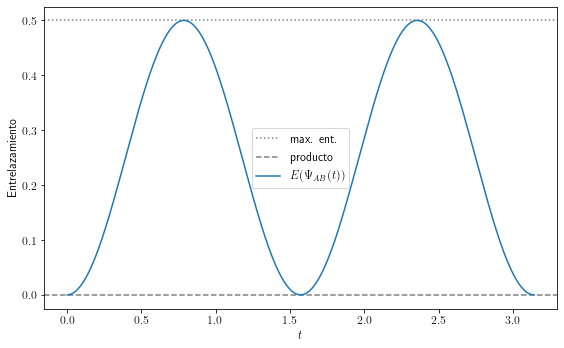

In [29]:
# Reproducimos gráfico que hicimos en clase
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.axhline(1/2, linestyle=':', color='gray', label='max. ent.')
ax.axhline(0, linestyle='--', color='gray', label='producto')
ax.plot(times, Eent, '-', color='C0', label='$E(\Psi_{AB}(t))$')
ax.set_xlabel('$t$')
ax.set_ylabel('Entrelazamiento')
ax.legend()

fig.tight_layout()
#fig.savefig('out/etunit.png', dpi=300)
plt.show()

## Problema 18 con campo externo

En la clase les dije que una versión más realista de esto tendría en cuenta el efecto de un campo magético sobre cada spin, de forma tal que uno podría por ejemplo escribir
$$H = -\boldsymbol{B}\cdot\boldsymbol{\sigma}\otimes\mathbb{1} - \mathbb{1}\otimes\boldsymbol{B}\cdot\boldsymbol{\sigma} + J\sigma_z\otimes\sigma_z$$
Les comenté que nada cambia desde un punto de vista cualitativo. Dado que ahora hacer estos cálculos es gratis, veamos que efectivamente es así.

### Campo paralelo
Veamos primero el caso en que el campo es paralelo a la interacción spin-spin.
Es decir,
$$H = -B\sigma_z\otimes\mathbb{1} - B\mathbb{1}\otimes\sigma_z + J\sigma_z\otimes\sigma_z$$
En tal caso, repitiendo todo lo de arriba, el entrelazamiento en función del tiempo es

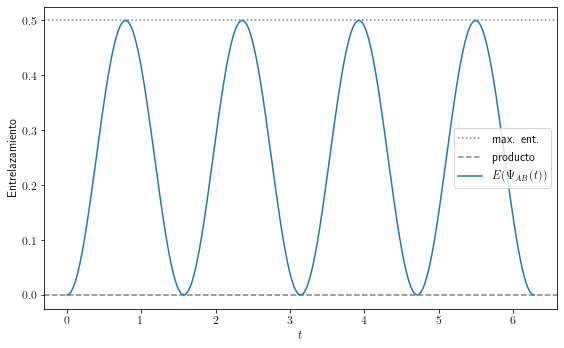

In [30]:
# Hamiltoniano: - B*Sz⊗1 - B*1⊗Sz + J*Sz⊗Sz
B, J = 2.0, 1.0
H = -B*tensor(sigmaz(),qeye(2)) - B*tensor(qeye(2),sigmaz()) +\
  J*tensor(sigmaz(),sigmaz())

# Estado Inicial evolucionado
times = np.linspace(0, 2*np.pi/J, 400)
res = mesolve(H, IniState, times)

# Estados reducidos primer subsitema, su pureza, y medida de entrelazamiento
reduced = [ state.ptrace(0) for state in res.states ]
purity = np.array([ (r**2).tr() for r in reduced ])
Eent = 1 - purity

# Gráfico equivalente al que hicimos en clase
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.axhline(1/2, linestyle=':', color='gray', label='max. ent.')
ax.axhline(0, linestyle='--', color='gray', label='producto')
ax.plot(times, Eent, '-', color='C0', label='$E(\Psi_{AB}(t))$')
ax.set_xlabel('$t$')
ax.set_ylabel('Entrelazamiento')
ax.legend()

fig.tight_layout()
#fig.savefig('out/etunitbpar.png', dpi=300)
plt.show()

Más allá de un cambio en la frecuencia, efectivamente nada cambió respecto a la evolución del entrelazamiento.

### Campo trasverso
Mucho más interesante es la situación de un campo trasverso, es decir que su dirección es perpendicular a la de la intreacción spin-spin. Tomamos entonces el Hamiltoniano
$$H = -B\sigma_z\otimes\mathbb{1} - B\mathbb{1}\otimes\sigma_z + J\sigma_x\otimes\sigma_x$$
Ahora, repitiendo todo lo de arriba, el entrelazamiento en función del tiempo es

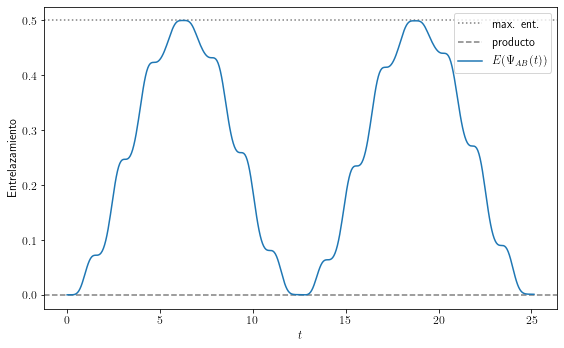

In [31]:
# Hamiltoniano: - B*Sz⊗1 - B*1⊗Sz + J*Sz⊗Sz
B, J = 1.0, 0.25
H = -B*tensor(sigmaz(),qeye(2)) - B*tensor(qeye(2),sigmaz()) +\
  J*tensor(sigmax(),sigmax())

# Estado Inicial evolucionado
times = np.linspace(0, 2*np.pi/J, 400)
res = mesolve(H, IniState, times)

# Estados reducidos primer subsitema, su pureza, y medida de entrelazamiento
reduced = [ state.ptrace(0) for state in res.states ]
purity = np.array([ (r**2).tr() for r in reduced ])
Eent = 1 - purity

# Gráfico equivalente al que hicimos en clase
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.axhline(1/2, linestyle=':', color='gray', label='max. ent.')
ax.axhline(0, linestyle='--', color='gray', label='producto')
ax.plot(times, Eent, '-', color='C0', label='$E(\Psi_{AB}(t))$')
ax.set_xlabel('$t$')
ax.set_ylabel('Entrelazamiento')
ax.legend()

fig.tight_layout()
#fig.savefig('out/etunitbtrans.png', dpi=300)
plt.show()

Como dije, *cualitativamente* no cambia nada.

(Si se ponen a jugar con los valores de $B$ y $J$ en este caso verán que al forma es bastante sensible, pero siempre se tiene algún tipo de oscilación en el entrelazamiento.)

## Efectos del entorno
La idea ahora es mostrarles los resultados de considerar la interacción con un entorno. Antes de pasar a ello cabe notar que, como ahora nuestros dos spins son una parte de algo más grande (el universo será spins + entorno), entonces el estado de los dos spins ya no será un estado puro, aún si comienza en un estado puro (efectivamente esto lo vimos justamente mirando el estado reducido de uno solo de los dos spins en el problema anterior). Por lo tanto, si queremos medir entrelazamiento, ya no podremos recurrir a la pureza del estado local.

Si leyeron el material que puse ayer sobre entrelazamiento en sistemas mixtos, medir el entrelazamiento es en general muy díficil en estos casos.
En una nota más alegre, aquí no estamos mirando cualquier sistema mixto, sino que un sistema compuesto por dos subsistemas de dimensión 2. Afortunadamente, para el caso de dos sistemas de dimensión 2 (y prácticamente solo para este caso) **sí** se conocen condiciones necesarias y suficientes para ser entrelazado aún en el caso mixto, y se conocen medidas de entrelazamiento que miden cuán entrelazado es el estado (ya sea mixto o puro). Hay más de una función de este tipo, una de las más conocidas y usadas es la *concurrencia*.

### Concurrencia (medida de entrelazamiento para dos qubits)
Como les decía, la concurrencia es una medida de entrelazamiento para sistemas compuestos de dos subsistemas de dimensión 2 y que funciona igual de bien para estados puros o mixtos. Acá no me voy a preocupar ni de dar su definición, porque aunque no es complicada, a simple vista no es para *nada* claro porqué mide el entrelazamiento. El que quiera puede mirar el [artículo (muy escueto) de Wikipedia](https://en.wikipedia.org/wiki/Concurrence_(quantum_computing)).
Más allá de su definición, la concurrencia $C(\rho_{AB})$ es tal que


*   $C(\rho_{AB}) = 0$ si y sólo si el estado es separable
*   $C(\rho_{AB}) > 0$ si y sólo si el estado es entrelazado
*   $C(\rho_{AB}) = 1$ si y sólo si el estado es máximamente entrelazado

Más aún, cuanto mayor la concurrencia, mayor el entrelazamiento (se dice que la concurrencia es una monótona del entrelazamiento).


Para ganar intuición de que efectivamente hace lo que les prometo, calculemos la concurrencia para el Problema 18 y comparemos con el gráfico de la medida que obtuvimos a partir de la pureza de la matriz densidad reducida.

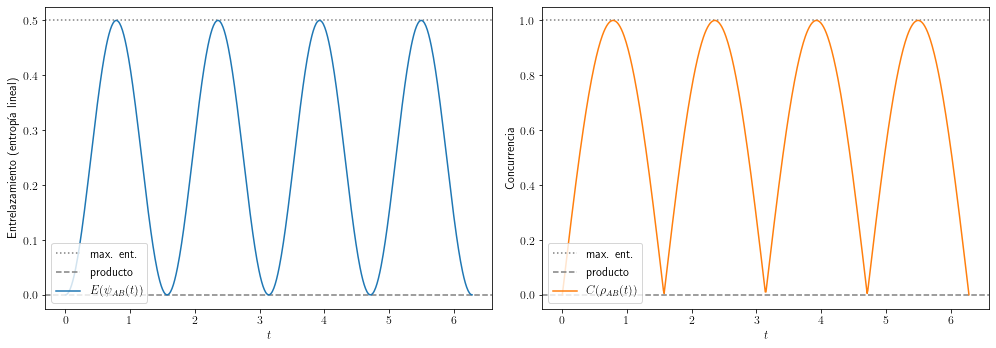

In [32]:
# Hamiltoniano: - B*Sz⊗1 - B*1⊗Sz + J*Sz⊗Sz
B, J = 2.0, 1.0
H = -B*tensor(sigmaz(),qeye(2)) - B*tensor(qeye(2),sigmaz()) +\
  J*tensor(sigmaz(),sigmaz())

# Estado Inicial evolucionado
times = np.linspace(0, 2*np.pi/J, 600)
res = mesolve(H, IniState, times)

# Estados reducidos primer subsitema, su pureza, y medida de entrelazamiento
reduced = [ state.ptrace(0) for state in res.states ]
purity = np.array([ (r**2).tr() for r in reduced ])
Eent = 1 - purity

# Concurrencia
C = np.array([ concurrence(state) for state in res.states ])

# Gráfico de comparación E vs C
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(14,5))

ax1.axhline(1/2, linestyle=':', color='gray', label='max. ent.')
ax1.axhline(0, linestyle='--', color='gray', label='producto')
ax1.plot(times, Eent, '-', color='C0', label='$E(\psi_{AB}(t))$')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Entrelazamiento (entropía lineal)')
ax1.legend(loc=3)

ax2.axhline(1, linestyle=':', color='gray', label='max. ent.')
ax2.axhline(0, linestyle='--', color='gray', label='producto')
ax2.plot(times, C, '-', color='C1', label='$C(\\rho_{AB}(t))$')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Concurrencia')
ax2.legend(loc=3)

fig.tight_layout()
#fig.savefig('out/evsc.png', dpi=300)
plt.show()

Se ve que ambas funciones están en el fondo midiendo la misma cosa (aunque de forma distinta). Efectivamente, ambas funciones van creciendo (y decreciendo) mónotonamente, y los puntos de máximo entrelazamiento y entrelazamiento nulo coinciden.

### Interacción con un entorno: amplitude damping (decaimiento al fundamental)
Ahora sí consideraremos los efectos del entorno. Como les dije en clase, el modelado de un entorno es el punto de partida de la Mecánica Cuántica de Sistemas Abiertos, que es un tema gigantesco y no se puede presentar en dos minutos. Así que simplemente les voy a comentar qué estoy modelando en palabras, y les queda el código que lo hace, pero en ningún momento voy a escribir una ecuación para la evolución temporal.

En primer lugar consideraremos una de las formas más sencillas de interacción con un entorno: el "amplitude damping", que básicamente es un decaimiento al estado fundamental. Efectivamente, para fijar ideas, supónganse que en cambio de spin 1/2 en sentido abstracto, nuestros dos sistemas de dimensión 2 son cada uno dos niveles de un átomo que pueden estar ocupados (el fundamental y el primer excitado). Como no les debería sorpender, si yo excito el electrón de un átomo, aunque pase exactamente a un autoestado de mayor energía, éste eventualmente va a decaer a su estado fundamental. Ésto debería parecerles razonable, pero desde un punto de vista de la teoría cuántica necesariamente nos está mostrando que el sistema está interactuando con algo externo, porque el primer excitado sino debería ser un estado estacionario y el electrón debería quedarse ahí para siempre. El hecho que un átomo decae a su estado fundamental es consecuencia directa de estar interactuando con un entorno con una infinidad de grados de libertad que se acoplan (aunque sea poco) con el átomo.

Aquí consideraremos este efecto del entorno sobre nuestro sistema, que modelamos de forma sencilla como una probabilidad $\gamma$ por unidad de tiempo de que cada spin decaiga del estado excitado al estado fundamental.
Veamos en tal caso qué sucede con el entrelazamiento (medido como concurrencia) en función del tiempo.

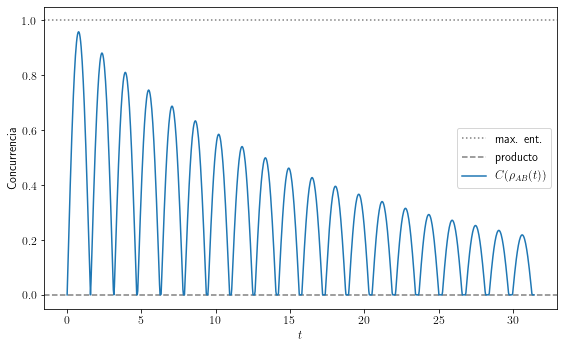

In [33]:
# Hamiltoniano: - B*Sz⊗1 - B*1⊗Sz + J*Sz⊗Sz
B, J = 2.0, 1.0
H = -B*tensor(sigmaz(),qeye(2)) - B*tensor(qeye(2),sigmaz()) +\
  J*tensor(sigmaz(),sigmaz())

# Disipación: 𝛾 probabilidad de decaer el estado fundamental
gamma = 0.2
L = [gamma*tensor(sigmap(),qeye(2)), gamma*tensor(qeye(2),sigmap())]

# Estado Inicial evolucionado
times = np.linspace(0, 10*np.pi/J, 900)
res = mesolve(H, IniState, times, L)

# Concurrencia
C = np.array([ concurrence(state) for state in res.states ])

# Gráfico de entrelazamiento (concurrencia)
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,5))

ax.axhline(1, linestyle=':', color='gray', label='max. ent.')
ax.axhline(0, linestyle='--', color='gray', label='producto')
ax.plot(times, C, '-', color='C0', label='$C(\\rho_{AB}(t))$')
ax.set_xlabel('$t$')
ax.set_ylabel('Concurrencia')
ax.legend()

fig.tight_layout()
#fig.savefig('out/cdecaydamp.png', dpi=300)
plt.show()

Notemos que tenemos oscilaciones en la cantidad de entrelazamiento, pero a diferencia de antes, ahora la amplitud decae (de hecho se puede mostrar decae exponencialmente con tasa fijada por $\gamma$).

Veamos un gráfico con varios $\gamma$ para comparar.

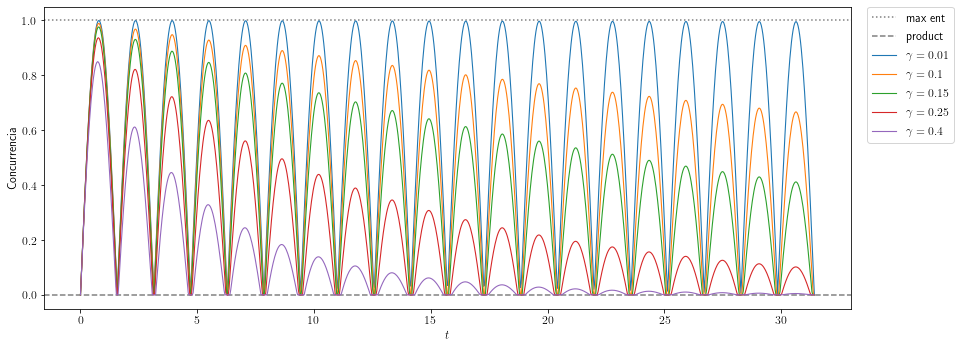

In [34]:
gammas = [ 0.01, 0.1, 0.15, 0.25, 0.4 ]
Cs = []
B, J = 2.0, 1.0
times = np.linspace(0, 10*np.pi/J, 900)
H = -B*tensor(sigmaz(),qeye(2)) - B*tensor(qeye(2),sigmaz()) +\
  J*tensor(sigmaz(),sigmaz())

for gamma in gammas:
    L = [gamma*tensor(sigmap(),qeye(2)), gamma*tensor(qeye(2),sigmap())]
    res = mesolve(H, IniState, times, L)
    C = np.array([ concurrence(state) for state in res.states ])
    Cs.append(C)

fig, ax = plt.subplots(1, 1, figsize=(14,5))

ax.axhline(1, linestyle=':', color='gray', label='max ent')
ax.axhline(0, linestyle='--', color='gray', label='product')
for idx,gamma in enumerate(gammas):
    ax.plot(times, Cs[idx], '-', linewidth=1.1,
             label='$\gamma = {}$'.format(gamma))
ax.set_xlabel('$t$')
ax.set_ylabel('Concurrencia')
ax.legend(bbox_to_anchor=(1.02,1), borderaxespad=0)

fig.tight_layout()
fig.subplots_adjust(right=0.85)
#fig.savefig('out/cdecaydampgammacomp.png', dpi=300)
plt.show()

Cuanto mayor $\gamma$, mayor la interacción con en el entorno y la disipación, lo cual a su vez nos causa una más rápida pérdida del entrelazamiento.

### Interacción con un entorno: termalización
La interacción anterior con el entorno es de lo más sencillo, simplemente tenemos una probabilidad $\gamma$ de decaer al fundamental. En un escenario aún más real, uno tiene probabilidad de decaer, pero también cada tanto probabilidad de excitarse debido a energía que le llega del entorno. Esto también lo podemos modelar, considerando ahora una probabilidad por unidad de tiempo $(1-g)\gamma$ de decaer al fundamental, y un probabilidad $g\gamma$ de excitarse. El caso anterior se corresponde a $g=0$. Rehaciendo lo mismo se tiene.

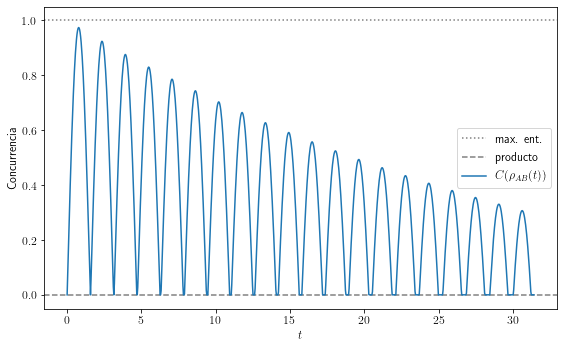

In [35]:
# Hamiltoniano: - B*Sz⊗1 - B*1⊗Sz + J*Sz⊗Sz
B, J = 2.0, 1.0
H = -B*tensor(sigmaz(),qeye(2)) - B*tensor(qeye(2),sigmaz()) +\
  J*tensor(sigmaz(),sigmaz())

# Disipación: 𝛾 probabilidad de decaer el estado fundamental
gamma, g = 0.2, 0.3
L = [(1-g)*gamma*tensor(sigmap(),qeye(2)), (1-g)*gamma*tensor(qeye(2),sigmap()),
     g*gamma*tensor(sigmam(),qeye(2)), g*gamma*tensor(qeye(2),sigmam())]

# Estado Inicial evolucionado
times = np.linspace(0, 10*np.pi/J, 900)
res = mesolve(H, IniState, times, L)

# Concurrencia
C = np.array([ concurrence(state) for state in res.states ])

# Gráfico de entrelazamiento (concurrencia)
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,5))

ax.axhline(1, linestyle=':', color='gray', label='max. ent.')
ax.axhline(0, linestyle='--', color='gray', label='producto')
ax.plot(times, C, '-', color='C0', label='$C(\\rho_{AB}(t))$')
ax.set_xlabel('$t$')
ax.set_ylabel('Concurrencia')
ax.legend()

fig.tight_layout()
#fig.savefig('out/cdecaytherm.png', dpi=300)
plt.show()

Notemos que en términos de la evolución del entrelazamiento se tiene básicamente lo mismo. En qué difieren entonces estas dos situaciones? Para ver eso, hay que ver cuáles son las evoluciones temporales de las matrices densidad reducidas de cada spin. En cambio de escribir matrices con números (que poco ayudan a visualizar lo que está pasando), haremos un gráfico de las matrices densidad, donde los colores indican el valor de cada coeficiente. Además, dada la simetría del problema, miraremos la matriz densidad reducida de uno solo de los spins.

Comencemos mirando al evolución temporal de la matriz densidad reducida para el caso de evolución unitaria sin baños ($\gamma = 0$).

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x16a35fdd0>)

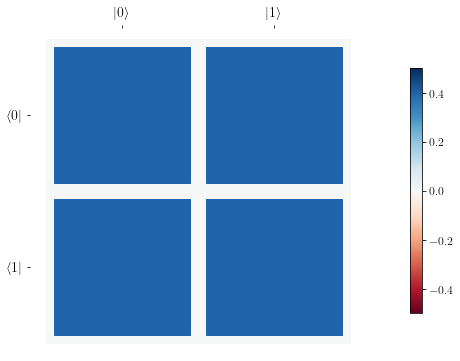

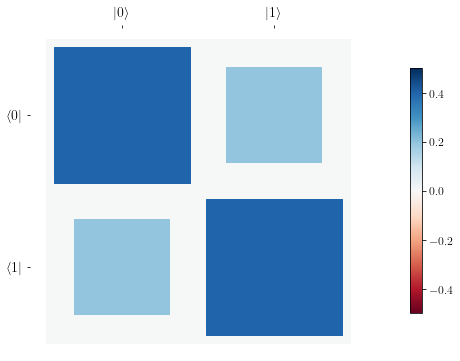

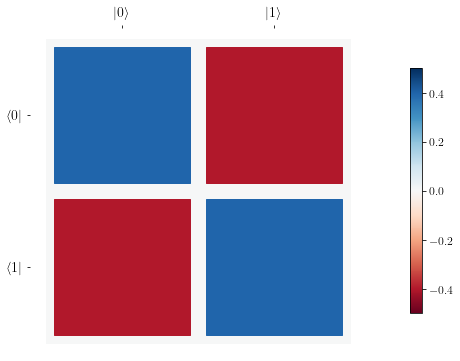

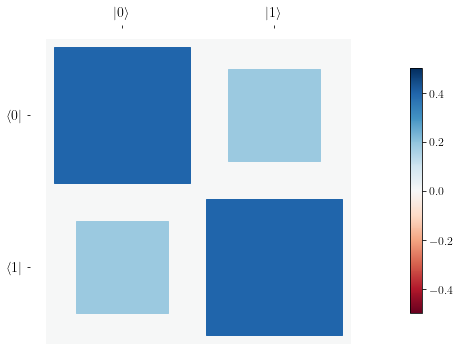

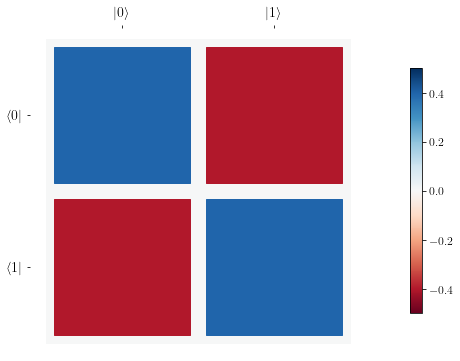

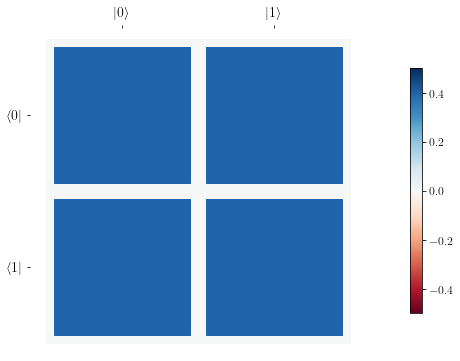

In [65]:
# Hamiltoniano: - B*Sz⊗1 - B*1⊗Sz + J*Sz⊗Sz
B, J = 2.0, 1.0
H = -B*tensor(sigmaz(),qeye(2)) - B*tensor(qeye(2),sigmaz()) +\
  J*tensor(sigmaz(),sigmaz())

# Disipación: 𝛾 probabilidad de decaer el estado fundamental
gamma, g = 0.0, 0.0
L = [(1-g)*gamma*tensor(sigmap(),qeye(2)), (1-g)*gamma*tensor(qeye(2),sigmap()),
     g*gamma*tensor(sigmam(),qeye(2)), g*gamma*tensor(qeye(2),sigmam())]

# Estado Inicial evolucionado
times = np.linspace(0, 10*np.pi/J, 900)
res = mesolve(H, IniState, times, L)

# Matriz densidad reducida primer spin
rhoA = []
for idx in range(len(times)):
    rhoA.append(res.states[idx].ptrace(0))

# Gráfico de la matriz densidad reducida a distintos tiempos
qt.hinton(rhoA[0])
qt.hinton(rhoA[len(times)//6])
qt.hinton(rhoA[len(times)//4])
qt.hinton(rhoA[len(times)*2//3])
qt.hinton(rhoA[len(times)*3//4])
qt.hinton(rhoA[-1])

Vemos que los términos diagonales no cambian, y los extra diagonales oscilan periódicamente.

Ahora, con $\gamma > 0$, pero $g = 0$.

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17cc79dd0>)

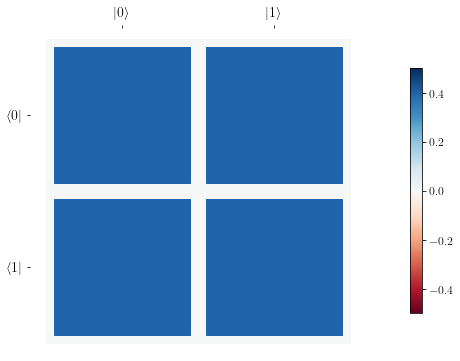

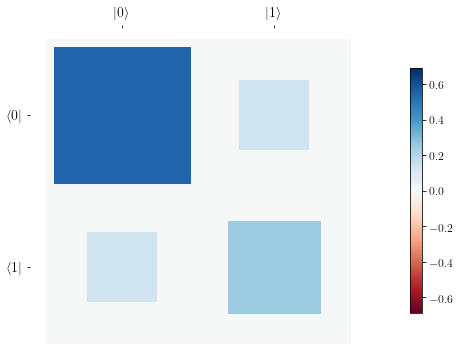

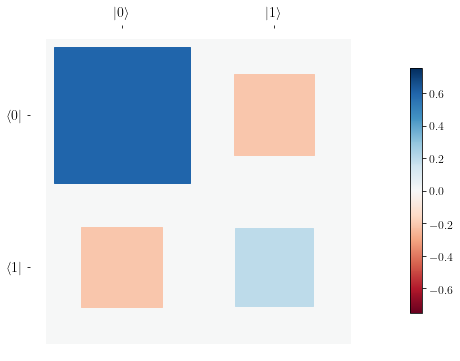

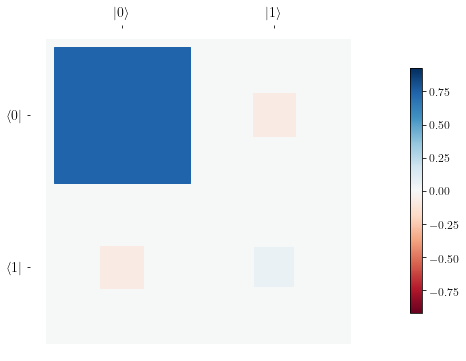

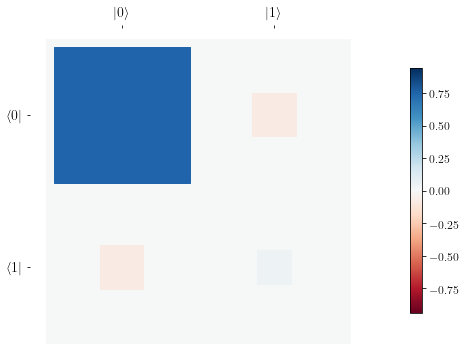

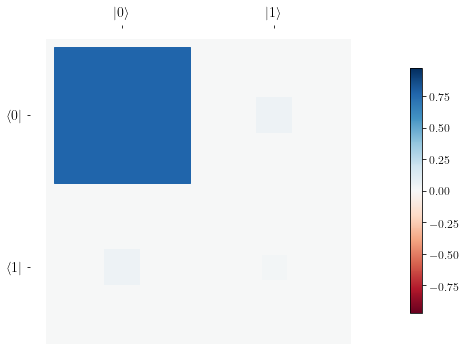

In [38]:
# Hamiltoniano: - B*Sz⊗1 - B*1⊗Sz + J*Sz⊗Sz
B, J = 2.0, 1.0
H = -B*tensor(sigmaz(),qeye(2)) - B*tensor(qeye(2),sigmaz()) +\
  J*tensor(sigmaz(),sigmaz())

# Disipación: 𝛾 probabilidad de decaer el estado fundamental
gamma, g = 0.3, 0.0
L = [(1-g)*gamma*tensor(sigmap(),qeye(2)), (1-g)*gamma*tensor(qeye(2),sigmap()),
     g*gamma*tensor(sigmam(),qeye(2)), g*gamma*tensor(qeye(2),sigmam())]

# Estado Inicial evolucionado
times = np.linspace(0, 10*np.pi/J, 900)
res = mesolve(H, IniState, times, L)

# Matriz densidad reducida primer spin
rhoA = []
for idx in range(len(times)):
    rhoA.append(res.states[idx].ptrace(0))

# Gráfico de la matriz densidad reducida a distintos tiempos
qt.hinton(rhoA[0])
qt.hinton(rhoA[len(times)//6])
qt.hinton(rhoA[len(times)//4])
qt.hinton(rhoA[len(times)*2//3])
qt.hinton(rhoA[len(times)*3//4])
qt.hinton(rhoA[-1])

Ahora los términos diagonales (que son las probabilidades de estar en los respectivos estados) no se presevan, y se puede observar el decaimiento al fundamental. Más aún, para los términos no diagonales (las coherencias, que en algún momento les comenté son indicios de "efectos cuánticos") hay oscilaciones pero la amplitud se va amortiguando al pasar el tiempo.

Finalmente, $\gamma > 0$, $g > 0$.

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x166f41d50>)

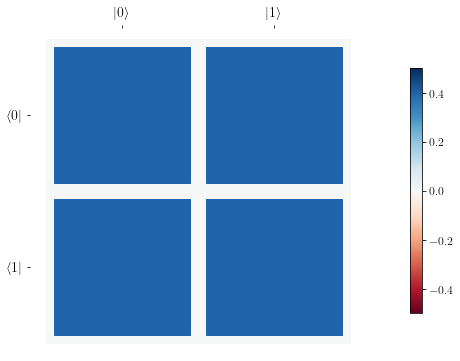

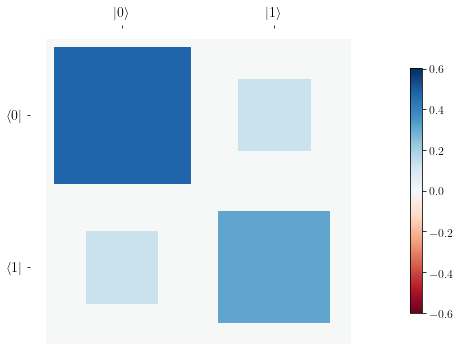

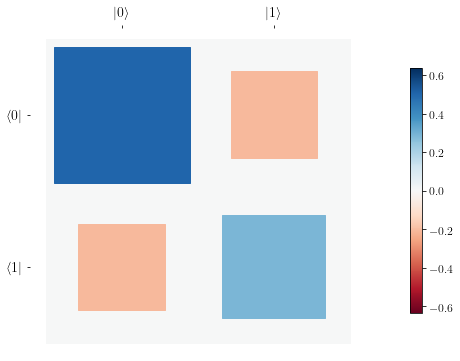

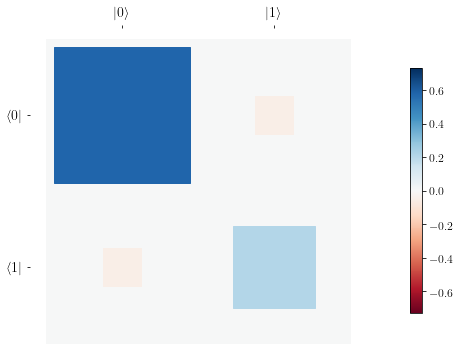

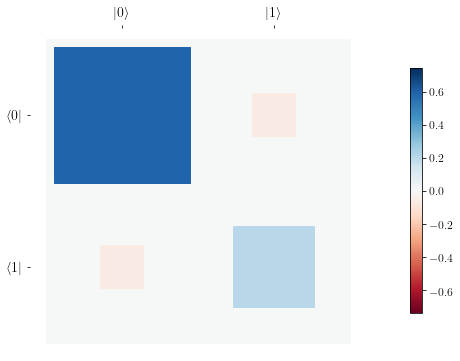

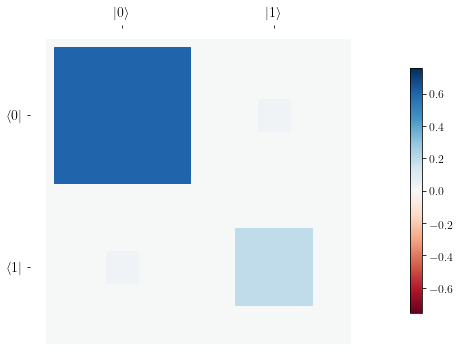

In [63]:
# Hamiltoniano: - B*Sz⊗1 - B*1⊗Sz + J*Sz⊗Sz
B, J = 2.0, 1.0
H = -B*tensor(sigmaz(),qeye(2)) - B*tensor(qeye(2),sigmaz()) +\
  J*tensor(sigmaz(),sigmaz())

# Disipación: 𝛾 probabilidad de decaer el estado fundamental
gamma, g = 0.4, 0.35
L = [(1-g)*gamma*tensor(sigmap(),qeye(2)), (1-g)*gamma*tensor(qeye(2),sigmap()),
     g*gamma*tensor(sigmam(),qeye(2)), g*gamma*tensor(qeye(2),sigmam())]

# Estado Inicial evolucionado
times = np.linspace(0, 10*np.pi/J, 900)
res = mesolve(H, IniState, times, L)

# Matriz densidad reducida primer spin
rhoA = []
for idx in range(len(times)):
    rhoA.append(res.states[idx].ptrace(0))

# Gráfico de la matriz densidad reducida a distintos tiempos
qt.hinton(rhoA[0])
qt.hinton(rhoA[len(times)//6])
qt.hinton(rhoA[len(times)//4])
qt.hinton(rhoA[len(times)*2//3])
qt.hinton(rhoA[len(times)*3//4])
qt.hinton(rhoA[-1])

Nuevamente, los términos no diagonales se anulan en el límite. Los términos diagonales tampoco se preservan, pero ahora convergen a una distribución con ambos estados, el fundamental y el excitado, poblados. Efectivamente, lo que se está describiendo con $\gamma > 0$ y $g > 0$ es un proceso de termalización del sistema donde la temperatura es $T = \frac{2B}{k_B\log[(1-g)/g]}$.

In [66]:
#for idx in range(len(times)):
#    qt.hinton(res.states[idx].ptrace(0))
#    plt.text(-2.0, 0.65, '$t = {:05d}$'.format(idx), bbox=dict(edgecolor='black', facecolor='white'))
#    plt.savefig('out/comp1/{:05d}.png'.format(idx))
#    plt.close()